<a href="https://colab.research.google.com/github/neohack22/IASD/blob/IA/IA/projects/presentation/privacy/PRIVACY_Notebook_6_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case Study - Health Care dataset

In this notebook, we'll explore the possibilties for data privacy on a new dataset.
Your challenge is that you are working with a health care provider, who would like to do the "machine learning" on this dataset to figure out if there are preventative measures that can be taken so fewer patients are seen in the hospital for related care or so that their visits are shorter, to do so you might want to predict the **has_diabetes** according to the features at hand. The goal is that more potentially affected patients are given access to primary care physicians and regular medication or visits that can keep them out of the hostpital for long stays.

## Part One: Determining What's Useful and What's Sensitive

- Data completeness
- Potential sensitive columns
- Potential useful features
- What columns should we use? 
- Which ones should we remove?
- Are there columns which we should protect but not remove? 

For each, we need some justification or thought!

In [1]:
import numpy as np
from matplotlib import rcParams

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
from sklearn.decomposition import PCA

In [4]:
from sklearn.linear_model import LogisticRegression

In [5]:
from sklearn.preprocessing import OneHotEncoder

In [6]:
import matplotlib.pyplot as plt

In [7]:
#@title
%matplotlib inline
import pandas as pd

df = pd.read_csv('/content/health_data.csv')

### Data completeness

In [8]:
print(df.isna().sum().sum() / df.size * 100)

0.0


In [9]:
df.isnull().any().any()

False

The data is complete as there are no null value nor missing value.

### Potential sensitive columns

We check for attributes that are not personally identifiable or quasi identifiable but still constitute data about the person that needs to be protected.<br>
This could be for any number of reasons, such as salary information, a diagnosis of a disease, or the geolocation.


In [10]:
for col in df:
  print(col)

admitted_ts
age
ambulance_call
blood_sugar_reading
days_since_last_visit
has_diabetes
hospital
hours_hospitalized
hydration_level
id
insulin
marital_status
no_primary_dr
patient_name
private_insurance
released_sameday
ssn
symptom_code


admitted_ts, ambulance_call, blood_sugar_reading, days_since_last_visit, has_diabetes, hospital, hours_hospitalized, hydration_level, insulin, private_insurance, released_sameday and symptom_code, as they're medical related are potential sentive columns.<br>
As we don't know the meaning of no_primary_dr, we consider it as potential sensitive as well.<br>
id, patient_name and ssn are even more sensitive as personal identifiable or quasi identifiable.


### Potential usefull features

We're going to analyze principal components of a predictive model in order to evaluate potential usefull features.<br>
To do so, we're start fitting a baseline model just to fit correlation between the target and the rest of the features.

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   admitted_ts            1000 non-null   object
 1   age                    1000 non-null   int64 
 2   ambulance_call         1000 non-null   int64 
 3   blood_sugar_reading    1000 non-null   int64 
 4   days_since_last_visit  1000 non-null   int64 
 5   has_diabetes           1000 non-null   int64 
 6   hospital               1000 non-null   object
 7   hours_hospitalized     1000 non-null   int64 
 8   hydration_level        1000 non-null   int64 
 9   id                     1000 non-null   int64 
 10  insulin                1000 non-null   int64 
 11  marital_status         1000 non-null   object
 12  no_primary_dr          1000 non-null   bool  
 13  patient_name           1000 non-null   object
 14  private_insurance      1000 non-null   int64 
 15  released_sameday      

Let's check correlations to focus on useful data.<br>
To do so, we would numerical columns so let's do the necessary transformations..

In [12]:
# categorical data
categorical_cols = ['hospital','marital_status','no_primary_dr']

dummy_df = pd.get_dummies(df, columns = categorical_cols)
print(dummy_df)

             admitted_ts  age  ambulance_call  blood_sugar_reading  \
0    2018-05-09 12:06:28   49               1                  108   
1    2018-05-12 10:02:55   82               1                   70   
2    2018-05-13 12:25:17   71               1                  100   
3    2018-05-14 12:20:08   87               0                  113   
4    2018-05-17 08:35:23   53               1                   93   
..                   ...  ...             ...                  ...   
995  2018-09-11 12:14:33   75               0                   83   
996  2018-09-13 10:09:36   73               0                   77   
997  2018-09-15 11:35:49   29               1                  109   
998  2018-09-18 08:41:36   23               0                   75   
999  2018-09-23 12:24:29   86               1                  126   

     days_since_last_visit  has_diabetes  hours_hospitalized  hydration_level  \
0                       99             1                  15                6 

In [13]:
dummy_df["admitted_ts"] = pd.to_datetime(dummy_df["admitted_ts"])
dummy_df["admitted_ts"] = pd.to_numeric(dummy_df["admitted_ts"])

In [14]:
corr = df.corr()
print("correlation", corr)

correlation                             age  ambulance_call  blood_sugar_reading  \
age                    1.000000       -0.039872            -0.093682   
ambulance_call        -0.039872        1.000000             0.028701   
blood_sugar_reading   -0.093682        0.028701             1.000000   
days_since_last_visit -0.025325        0.000858             0.018231   
has_diabetes          -0.004673        0.013858            -0.003593   
hours_hospitalized     0.036598       -0.039157            -0.007363   
hydration_level        0.013655        0.016497            -0.003371   
id                    -0.031231        0.019323             0.039533   
insulin                0.009212       -0.031877            -0.042906   
no_primary_dr          0.001633        0.011651             0.073805   
private_insurance      0.022074       -0.057674            -0.017256   
released_sameday      -0.094541        0.044267             0.007559   
symptom_code          -0.076882       -0.013384     

We can drop 'admitted_ts' as it has no correlation whatsoever with the target.

In [15]:
# drop categorical columns not correlated to target or that can cause leakage
pca_ddf = dummy_df.drop(
    ['admitted_ts', 'patient_name', 'ssn', 'id'], axis=1)

In [16]:
X = pca_ddf.drop('has_diabetes', axis=1)
y = pca_ddf['has_diabetes']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [17]:
pca = PCA().fit(X_train)

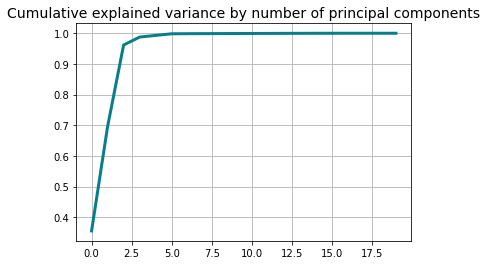

In [18]:
plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.title(
    'Cumulative explained variance by number of principal components', size=14)
plt.grid()    
plt.show()

We can explain more more than 99% of the variance in the source dataset with the first five principal components.<br>
We're going to check loadings (coefficients of the linear combination of the original variables from which the principal components are constructed), coefficients of the linear combination of the original variables from which the principal components are constructed.<br>
Indeed if there's a strong correlation between the principal component and an original variable, it means this feature is important.

In [19]:
loadings = pd.DataFrame(
    data = pca.components_.T * np.sqrt(pca.explained_variance_),
    columns=[f'PC{i}' for i in range(1, len(X_train.columns) + 1)],
    index=X_train.columns
)
loadings.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
age,-9.066559,1.964975,-18.651862,-0.036933,0.035986,-0.031850,0.000334,0.000133,0.000071,0.000301,0.000590,0.000679,0.000069,-0.000158,0.000089,-0.000268,-0.000505,8.806542e-35,1.040696e-34,1.994475e-35
ambulance_call,0.007441,-0.005562,0.019056,-0.013956,-0.019021,0.013097,0.021348,0.087779,-0.141519,-0.015333,0.360163,0.139155,-0.217348,-0.141246,0.009954,0.065325,0.002527,1.436919e-32,-1.085483e-32,1.888617e-33
blood_sugar_reading,16.968793,-13.595883,-7.282174,0.032685,0.010484,0.010903,-0.001614,-0.000788,-0.000155,0.000160,0.000401,-0.000645,0.000161,-0.000294,0.000148,-0.000107,-0.000035,2.692032e-34,-4.119806e-35,1.858369e-34
days_since_last_visit,13.481297,18.435795,-3.381108,0.012062,0.011305,0.004352,-0.000361,0.000514,-0.000494,0.000300,0.000089,-0.000636,-0.000335,0.000167,0.000017,-0.000401,-0.000034,1.353423e-34,4.120457e-35,-1.627916e-34
hours_hospitalized,-0.164652,0.046918,-0.067290,6.321838,-0.051345,-0.001798,-0.000381,0.001541,-0.000462,-0.001282,-0.000018,-0.000103,-0.001446,0.001406,-0.000170,0.004096,-0.016342,-8.816816e-34,1.275635e-33,3.553209e-34


The first principal component is crucial as it explains more than 98% of the variance in the dataset.<br>
So let's visualize the correlations between all of the input features and the first principal component.

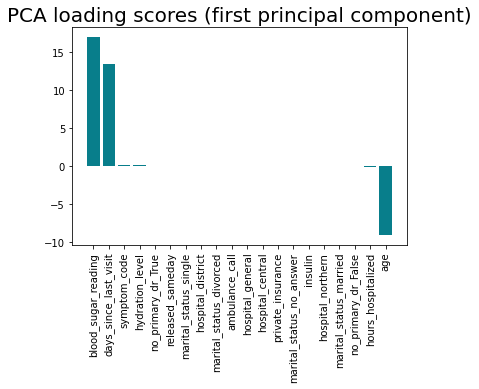

In [20]:
pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
pc1_loadings = pc1_loadings.reset_index()
pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']

plt.bar(
    x=pc1_loadings[
        'Attribute'], height=pc1_loadings[
            'CorrelationWithPC1'], color='#087E8B')
plt.title('PCA loading scores (first principal component)', size=20)
plt.xticks(rotation='vertical')
plt.show()

We can see that potential useful features are:
1.   blood_sugar_reading, 
2.   days_since_last_visit,
3.   age,
4.   symptom_code,     
5.   hydration_level and
6.   hours_hospitalized



### What columns should we use?

We should use at least those that are correlated the most, being: blood_sugar_reading, days_since_last_visit, age and symptom_code.<br>
Those feature make indeed sense from our understanding of diabetes.

### Which ones should we remove?

We should remove the unique identifiers that can cause leakage and identify a person: id, ssn, patient_name.

### Are there columns which we should protect but not remove?

The potential sensitive medical columns correlated should be protected: ambulance_call, blood_sugar_reading, days_since_last_visit, has_diabetes, hours_hospitalized, hydration_level, insulin, private_insurance, released_sameday and symptom_code.

## Part Two: Determining the Approach for protecting the Columns

**What methods will be most effective?**

We will:


*   remove personal information
*   protect sensitive information
*   send only the most correlated data first



**Have you considered potential data leakage within *non-sensitive* columns?**

We have considered potential data leakage within non-sensitive columns but the riskier leakage came from id (sensitive), as it's a unique value that can cause overfitting.

**Is there other sensitive or secret data we should address?**

The dataset is not concerned by any other non medical sensitive or secret information such as salary or geolocation.
<br>
```hospital``` could have been discussed but as it's medical, it has already been taken into account.

In [21]:
X_minimal = X[
    ['blood_sugar_reading', 'days_since_last_visit', 'age', 'symptom_code', 'hydration_level', 'hours_hospitalized']]

## Part Three: Implement Data Protection for the Dataset

In [22]:
# generate a random sample

def simlap(n, b):
    """
    :param     n: The number of samples to draw
    :param     b: Scale of the distribution.
    :    returns: a vector of size n with noises sample from laplace dristribution.
    """
    liste=[]
    for i in range(n):
      liste.append(np.random.laplace(loc=0.0, scale=b ))
    return liste

In [24]:
def process_value(value, p, q):
    """
    :param value: The value to apply the differentially private scheme to.
    :param     p: The probability of returning a random value instead of the true one
    :param     q: The probability of returning 1 when generating a random value
    :    returns: A new, differentially private value
    """
    valeur_aleatoire_1 = np.random.rand()
    if p >= valeur_aleatoire_1:
      valeur_aleatoire_2 = np.random.rand()
      if q >= valeur_aleatoire_2:
        return 0
      return 1  
    else:
      return value

In [33]:
p=q=0.5

X_minimal[
    'blood_diff_private']=X_minimal[
        'blood_sugar_reading'].apply(lambda x :process_value(x, p, q  ))
X_minimal[
    'visit_diff_private']=X_minimal[
        'days_since_last_visit'].apply(lambda x :process_value(x, p, q  ))
X_minimal[
    'age_diff_private']=X_minimal['age'].apply(lambda x :process_value(x, p, q))
X_minimal[
    'symptom_diff_private']=X_minimal[
        'symptom_code'].apply(lambda x :process_value(x, p, q  ))
X_minimal[
    'hydration_diff_private']=X_minimal[
        'hydration_level'].apply(lambda x :process_value(x, p, q  ))
X_minimal[
    'hours_diff_private']=X_minimal[
        'hours_hospitalized'].apply(lambda x :process_value(x, p, q  ))

Liste_valeurs_calculées_DF=[]
for i, j in enumerate(df['blood_sugar_reading']):
    Liste_valeurs_calculées_DF.append (process_value(j, p, q))
X_minimal['blood_diff_private'] = np.array(Liste_valeurs_calculées_DF)

Liste_valeurs_calculées_DF=[]
for i, j in enumerate(df['days_since_last_visit']):
    Liste_valeurs_calculées_DF.append (process_value(j, p, q))
X_minimal['visit_diff_private'] = np.array(Liste_valeurs_calculées_DF)

Liste_valeurs_calculées_DF=[]
for i, j in enumerate(X_minimal['age']):
    Liste_valeurs_calculées_DF.append (process_value(j, p, q))
X_minimal['age_diff_private'] = np.array(Liste_valeurs_calculées_DF)

Liste_valeurs_calculées_DF=[]
for i, j in enumerate(X_minimal['symptom_code']):
    Liste_valeurs_calculées_DF.append (process_value(j, p, q))
X_minimal['symptom_diff_private'] = np.array(Liste_valeurs_calculées_DF)

Liste_valeurs_calculées_DF=[]
for i, j in enumerate(X_minimal['hydration_level']):
    Liste_valeurs_calculées_DF.append (process_value(j, p, q))
X_minimal['hydration_diff_private'] = np.array(Liste_valeurs_calculées_DF)

Liste_valeurs_calculées_DF=[]
for i, j in enumerate(X_minimal['hours_hospitalized']):
    Liste_valeurs_calculées_DF.append (process_value(j, p, q))
X_minimal['hours_diff_private'] = np.array(Liste_valeurs_calculées_DF)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

In [29]:
# write estimator

def p_1_estimator(p_1dp, p, q):
    """
    :param p_1dp: The empirical probability of x_i=1 of our DP dataset.
    :param     p: The p value of our DP scheme.
    :param     q: The q value of our DP scheme.
    :    returns: An estimate of p_1 of our DP dataset.
    """
    return  (p_1dp - p*(1 - q) ) / (1 - p)

print(p_1_estimator(0.1, 0.5, 0.5) )

-0.3


In [34]:
# generate estimate of p_1

p=q=0.5
n = len(df)

p1_dp0=X_minimal['blood_diff_private'].sum() / n
p1_dp1=X_minimal['visit_diff_private'].sum() / n
p1_dp2=X_minimal['age_diff_private'].sum() / n
p1_dp3=X_minimal['symptom_diff_private'].sum() / n
p1_dp4=X_minimal['hydration_diff_private'].sum() / n
p1_dp5=X_minimal['hours_diff_private'].sum() / n

In [35]:
# estimate variance

def var_1_estimator(p1_dp, n, p, q):
    """
    :param p_1dp: The estimates probability of our DP dataset.
    :param     n: The number of samples in our dataset.
    :param     p: The p value of our DP scheme.
    :param     q: The q value of our DP scheme.
    :    returns: An estimate of the variance of our DP dataset.
    """
    return ( p1_dp*(1 - p1_dp)) / ( ((1 - p)**2) * n)
    
var_1_hat0 = var_1_estimator(p1_dp0, len(df), p, q)    
var_1_hat1 = var_1_estimator(p1_dp1, len(df), p, q)
var_1_hat2 = var_1_estimator(p1_dp2, len(df), p, q)
var_1_hat3 = var_1_estimator(p1_dp3, len(df), p, q)
var_1_hat4 = var_1_estimator(p1_dp4, len(df), p, q)
var_1_hat5 = var_1_estimator(p1_dp5, len(df), p, q)

print(var_1_hat0, var_1_hat1, var_1_hat2, var_1_hat3, var_1_hat4, var_1_hat5)



-10.875821264 -3.2591816039999997 -2.745598464 -0.016255716 -0.016556100000000004 -0.10096960400000002


In [37]:
# repeat the generation process

p=q=0.5
n = len(X_minimal)

p1_dp0=X_minimal['blood_diff_private'].sum() / n
p_1_hats0=[]
for j in range(500):
  X_minimal[
      'blood_diff_private']=X_minimal[
          'age'].apply(lambda x :process_value(x, p, q  ))
  """
    valeurs_calculées_par_DP = []
    for i, x in enumerate(X_minimal['blood_diff_private']):
        valeurs_calculées_par_DP.append (process_value(x, p, q))

    X_minimal['income_diff_private'] = np.array(valeurs_calculées_par_DP)
  """
  p_1dp0 = X_minimal['blood_diff_private'].sum()/len(df)
  p_1_hat0 = p_1_estimator(p_1dp0, p, q)
  p_1_hats0.append(p_1_hat0)
p_1_hats0 = np.array(p_1_hats0)
p_1_hats0[0:20]


p1_dp1=X_minimal['visit_diff_private'].sum() / n 
p_1_hats1=[]
for j in range(500):
  X_minimal[
      'visit_diff_private']=X_minimal[
          'days_since_last_visit'].apply(lambda x :process_value(x, p, q  ))
  """
    valeurs_calculées_par_DP = []
    for i, x in enumerate(df['income_binaire']):
        valeurs_calculées_par_DP.append (process_value(x, p, q))

    df['visit_diff_private'] = np.array(valeurs_calculées_par_DP)
  """
  p_1dp1 = X_minimal['visit_diff_private'].sum()/len(df)
  p_1_hat1 = p_1_estimator(p_1dp1, p, q)
  p_1_hats1.append(p_1_hat1)
p_1_hats1 = np.array(p_1_hats1)
p_1_hats1[0:20]


p1_dp2=X_minimal['age_diff_private'].sum() / n 
p_1_hats2=[]
for j in range(500):
  X_minimal[
      'age_diff_private']=X_minimal[
          'age'].apply(lambda x :process_value(x, p, q  ))
  """
    valeurs_calculées_par_DP = []
    for i, x in enumerate(X_minimal['age_diff_private']):
        valeurs_calculées_par_DP.append (process_value(x, p, q))

    X_minimal['income_diff_private'] = np.array(valeurs_calculées_par_DP)
  """
  p_1dp2 = X_minimal['age_diff_private'].sum()/len(df)
  p_1_hat2 = p_1_estimator(p_1dp2, p, q)
  p_1_hats2.append(p_1_hat2)
p_1_hats2 = np.array(p_1_hats2)
p_1_hats2[0:20]
p1_dp=X_minimal['symptom_diff_private'].sum() / n


p_1_hats3=[]
for j in range(500):
  X_minimal[
      'symptom_diff_private']=X_minimal[
          'symptom_code'].apply(lambda x :process_value(x, p, q  ))
  """
    valeurs_calculées_par_DP = []
    for i, x in enumerate(df['symptom_diff_private']):
        valeurs_calculées_par_DP.append (process_value(x, p, q))

    X_minimal['symptom_diff_private'] = np.array(valeurs_calculées_par_DP)
  """
  p_1dp3 = X_minimal['symptom_diff_private'].sum()/len(X_minimal)
  p_1_hat3 = p_1_estimator(p_1dp3, p, q)
  p_1_hats3.append(p_1_hat3)
p_1_hats3 = np.array(p_1_hats3)
p_1_hats3[0:20]


p1_dp4=X_minimal['hours_diff_private'].sum() / n
p_1_hats4=[]
for j in range(500):
  X_minimal[
      'hours_diff_private']=X_minimal[
          'hours_hospitalized'].apply(lambda x :process_value(x, p, q  ))
  """
    valeurs_calculées_par_DP = []
    for i, x in enumerate(X_minimal['hours_hospitalized']):
        valeurs_calculées_par_DP.append (process_value(x, p, q))

    X_minimal['hours_diff_private'] = np.array(valeurs_calculées_par_DP)
  """
  p_1dp4 = X_minimal['hours_diff_private'].sum()/len(df)
  p_1_hat4 = p_1_estimator(p_1dp4, p, q)
  p_1_hats4.append(p_1_hat4)
p_1_hats4 = np.array(p_1_hats4)
p_1_hats4[0:20]


p1_dp5=X_minimal['hydration_diff_private'].sum() / n
p_1_hats5=[]
for j in range(500):
  df[
      'hydration_diff_private']=X_minimal[
          'hydration_level'].apply(lambda x :process_value(x, p, q  ))
  """
    valeurs_calculées_par_DP = []
    for i, x in enumerate(df['hydration_level']):
        valeurs_calculées_par_DP.append (process_value(x, p, q))

    df['hydration_diff_private'] = np.array(valeurs_calculées_par_DP)
  """
  p_1dp5 = X_minimal['hydration_diff_private'].sum()/len(X_minimal)
  p_1_hat5 = p_1_estimator(p_1dp5, p, q)
  p_1_hats5.append(p_1_hat5)
p_1_hats5 = np.array(p_1_hats5) 
p_1_hats5[0:20]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

array([4.69, 4.69, 4.69, 4.69, 4.69, 4.69, 4.69, 4.69, 4.69, 4.69, 4.69,
       4.69, 4.69, 4.69, 4.69, 4.69, 4.69, 4.69, 4.69, 4.69])

**What was difficult to decide and implement?**

It was first difficult to decide which method to chose, which data to remove, which to protect and at which step to implement it all.<br>
We eventually chose Laplace transformation that was convenient for numeric data we were dealing with, a reasonable tradeoff between utility and privacy for our usecase and scalable.<br>
We removed all the data that wouldn't statistically have a significant impact on our model.<br>
The questions helped track the steps where to transform data.

**How might this relate to real problems in machine learning with sensitive data?**

This might relate to real problems such as an hospital having to decide which data to duplicate from their production environment to their development environment within their datahub so that a data team could work with it for example.

### Bonus: machine learning from anonymized Dataset

Build a model that predicts the the diabetes statue of a new patient based on the anonymized database from part three. Compare with non anonymized dataset. (try to get more than 0.65 accuracy)

In [38]:
train_Xm, test_Xm, train_y, test_y = train_test_split(
    X_minimal, y, test_size=0.25, random_state=42
)

In [40]:
# Train a baseline logistic regression
diabetes_check = LogisticRegression(max_iter=1000)
#diabetes_check.fit(X_train, y_train)
diabetes_check.fit(train_Xm, train_y)

LogisticRegression(max_iter=1000)

In [41]:
train_y

82     1
991    1
789    1
894    1
398    1
      ..
106    1
270    1
860    1
435    1
102    1
Name: has_diabetes, Length: 750, dtype: int64

In [42]:
rcParams['figure.figsize'] = 14, 7
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

In [43]:
score = diabetes_check.score(test_Xm, test_y)
print("Test Accuracy Score", score)

Test Accuracy Score 0.76


In [44]:
# Train a baseline logistic regression
comparison_check = LogisticRegression(max_iter=1000)
comparison_check.fit(X_train, y_train)

comparison_score = comparison_check.score(X_test, y_test)
print("Comparison Accuracy Score", comparison_score)

Comparison Accuracy Score 0.76


We get the same test accuracy score, no matter we use anonymized or non anonymized dataset.<br>
As introducing non protected features didn't change our accuracy, we can conclude that our dataset was correctly anonymized.<br>
We just have to take into acount that even the non-anonymized dataset is not protected by default for machine learning purposes as we need to remove unique identifiers, that would be personal information, for data leakage prevention.

It confirms our conclusion at the previous notebooks:
*   privacy increase can have either reduce or maintain accuracy
*   the accuracy of the model depends on the distribution of the features, not on the actual values (reason why we can standardize numerical values for example to have a better representation).